In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import csv
import math
from tensorflow import keras


import cv2
import numpy as np
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten
import tensorflow as tf
from keras.datasets import cifar10
import sys
import matplotlib.pyplot as plt
print(tf.__version__)
#print(tf.keras.__version__)

#testing the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


2024-02-18 03:35:23.175403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-18 03:35:23.175429: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-18 03:35:23.175432: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-18 03:35:23.175461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 03:35:23.175477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# resize train images to 10000 images
train_images = train_images[0:10000]
train_labels = train_labels[0:10000]

print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between -1 and 1 [you can normalize between 0 and 1 also]
train_images = train_images / 127.5 - 1
test_images = test_images / 127.5 - 1

Training data seize: (10000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

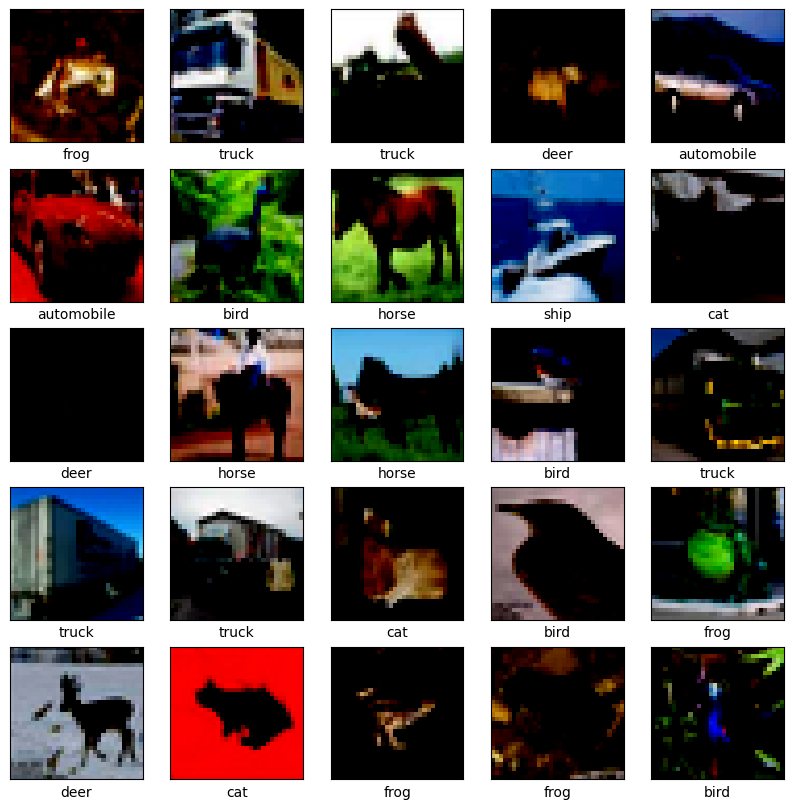

In [3]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Resize images for use with MobileNetV2

In [4]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2
resized_train_images = np.array([cv2.resize(img, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA) for img in train_images])

resized_test_images = np.array([cv2.resize(img, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA) for img in test_images])
input_shape = (minSize, minSize, 3)

print ('Resized Training data seize:', resized_train_images.shape, 'Resized Test data size', resized_test_images.shape)

Resized Training data seize: (10000, 96, 96, 3) Resized Test data size (10000, 96, 96, 3)


### Download MobileNetV2 model



In [5]:
#<Write code for downloading MobileNetV2>
base_model = MobileNetV2(input_shape=(minSize, minSize, 3), include_top=False, weights='imagenet')

2024-02-18 03:35:27.091194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 03:35:27.091224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Add custom layers at the end of downloaded model

In [6]:
#<Write code for adding custom layers>
model = tf.keras.Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

### Add loss function, compile and train the model, and check accuracy on test data

In [7]:
# Loss Function
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Run stochastic gradient descent for 10 epochs
epochs = 15
batch_size = 8
history = model.fit(resized_train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(resized_test_images, test_labels))

Epoch 1/10


2024-02-18 03:35:29.950393: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-18 03:35:31.455339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.6777 - accuracy: 0.5331

2024-02-18 03:35:57.048978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 33s 95ms/step - loss: 1.6777 - accuracy: 0.5331 - val_loss: 19.3199 - val_accuracy: 0.1002
Epoch 2/10
313/313 [==============================] - 26s 83ms/step - loss: 1.3212 - accuracy: 0.6135 - val_loss: 7.0017 - val_accuracy: 0.1230
Epoch 3/10
313/313 [==============================] - 26s 81ms/step - loss: 0.9935 - accuracy: 0.7076 - val_loss: 4.2640 - val_accuracy: 0.2075
Epoch 4/10
313/313 [==============================] - 26s 82ms/step - loss: 0.8026 - accuracy: 0.7584 - val_loss: 4.6634 - val_accuracy: 0.2315
Epoch 5/10
313/313 [==============================] - 25s 79ms/step - loss: 0.7300 - accuracy: 0.7858 - val_loss: 3.8615 - val_accuracy: 0.3096
Epoch 6/10
313/313 [==============================] - 25s 78ms/step - loss: 0.7046 - accuracy: 0.7935 - val_loss: 5.2641 - val_accuracy: 0.3312
Epoch 7/10
313/313 [==============================] - 25s 78ms/step - loss: 0.6088 - accuracy: 0.8183 - val_loss: 4.3280 - val_accuracy: 0.3858
Ep

In [10]:
# Check accuracy
test_loss, test_acc = model.evaluate(resized_test_images, test_labels)

313/313 [==============================] - 6s 18ms/step - loss: 6.7856 - accuracy: 0.3429
